In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm 
from sklearn import linear_model 
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import numpy as np
from sklearn import metrics

import math
def df_r(sc, d_f):
    d_f[d_f.columns.values] = sc.inverse_transform(d_f[d_f.columns.values])
    return d_f
def accuracy_val(YY_test,predictt_result):
    text_index=    {
        'Label':'Label',
        'Y_RFR_pred':'Ground truth',
        'Y_svm_pred':'svm.SVR',
        'Y_BR_pred':'BayesianRidge',
        'Y_KNN_pred':'KNN'
    }
        
    lab = YY_test['Label'][:-1].reset_index() -YY_test['Label'][1:].reset_index() 
    lab[lab<0]=-1
    lab[lab>0]=1
    out = predictt_result[:-1].reset_index() -predictt_result[1:].reset_index() 
    out[out<0]=-1
    out[out>0]=1
    out = out.drop(['index'], axis=1)
    out_str=''
    for name in out:
        ans = out[name]==lab['Label']

        out_str+=text_index[name]+' Direction Accuracy:'+str(sum(ans)/len(out[name]))+'\n'
    return out_str

def show_plot_dataframe(title_name, predictt_result, YY_test,f_n,label_nal,training_set):

    YY_test = df_r(label_nal, YY_test.copy())
    predictt_result = df_r(label_nal, predictt_result.copy())

    x = np.linspace(1,len(YY_test),len(YY_test))
    ax=plt.figure(figsize=(20,10))
    
    l1 = plt.plot(x, YY_test['Label'].values.tolist(),     label='true', linestyle="--")
    l2 = plt.plot(x, predictt_result['Y_RFR_pred'],        label='RandomForestRegressor')
    l4 = plt.plot(x, predictt_result['Y_svm_pred'],        label='svm.SVR')
    l6 = plt.plot(x, predictt_result['Y_BR_pred'],         label='BayesianRidge')
    l11 = plt.plot(x, predictt_result['Y_KNN_pred'],       label='KNN')
    
    m = math.floor(len(YY_test)/30)
    x_range_n = np.arange(1,len(YY_test),1 if m<=0 else m)
    plt.xticks(x_range_n, training_set['Date'][YY_test.index.values[x_range_n]],rotation=75)
    plt.legend(loc='upper left')
    plt.title(title_name)

    plt.savefig(f_n+'.jpg')

from sklearn.metrics import accuracy_score
def Shaking(T):
    T  = T[0:-2]-T[1:-1]
    T[T<0]=-1
    T[T>0]=1
    return T

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100
def evaluation(y_true, x_true, y_pred,title_name):
    y_true = np.reshape(np.array(y_true),(y_true.shape[0]))
    x_true = np.reshape(np.array(x_true),(x_true.shape[0]))
    y_pred = np.array(y_pred)
    MSE_   = str(metrics.mean_squared_error(y_true, y_pred))
    RMSE_  = str(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    MAE_   = str(metrics.mean_absolute_error(y_true, y_pred))
    MAPE_  = str(mape(y_true, y_pred))
    SMAPE_ = str(smape(y_true, y_pred))
    return '\t'+title_name+':\n \t\tRMSE:'+RMSE_+'\n\t\tMAPE:'+MAPE_+'\n'
    
def print_evaluation(X_test, Y_test, predict_result,f_n):
    
    s1=evaluation(Y_test, X_test['Close'], predict_result['Y_RFR_pred'],  'RandomForestRegressor')
    s2=evaluation(Y_test, X_test['Close'], predict_result['Y_svm_pred'],  'svm.SVR')
    s3=evaluation(Y_test, X_test['Close'], predict_result['Y_KNN_pred'],  'KNN')
    s4=evaluation(Y_test, X_test['Close'], predict_result['Y_BR_pred'],   'BayesianRidge')

    print(s1+s2+s3+s4)

def set_train_model():
    RFR = RandomForestRegressor( verbose=0, random_state=1234,max_depth=51) 
    svm_ = svm.LinearSVR(random_state=1234)
    KNN = KNeighborsRegressor(n_neighbors=2)
    BR = linear_model.BayesianRidge()
    TSR=linear_model.TheilSenRegressor()
    MTENCV = linear_model.MultiTaskElasticNetCV()
    MTENSSOCV = linear_model.MultiTaskLassoCV()
    return [RFR, svm_, KNN, BR] 

def run_gridsearch(set_m, X_train,y_train,X_test,y_test):
    y_test = np.array(y_test).ravel()
    y_train = np.array(y_train).ravel()
    RF_param = {"n_estimators":[10,100,1000]}
    GSCV = GridSearchCV(set_m[0],param_grid=RF_param,cv=5)
    GSCV.fit(X_train,y_train)
    print("accuracy score",GSCV.score(X_test,y_test))
    print("The best model param :",GSCV.best_params_)
def set_train_fit(XX_, YY_, set_m):
    YY_ = np.array(YY_).ravel()
    set_m[0].fit(XX_, YY_)
    set_m[1].fit(XX_, YY_)
    set_m[2].fit(XX_, YY_)
    set_m[3].fit(XX_, YY_)

    return set_m.copy()

def train_predict(XX_, YY_, set_m):
    Y_RFR_pred = set_m[0].predict(XX_)
    Y_svm_pred = set_m[1].predict(XX_)
    Y_KNN_pred = set_m[2].predict(XX_)
    Y_BR_pred  = set_m[3].predict(XX_)

    predict_result    = pd.DataFrame([  
                            Y_RFR_pred,
                            Y_svm_pred,
                            Y_KNN_pred,
                            Y_BR_pred
                                  ]).T
    predict_result.columns=[
                            'Y_RFR_pred',
                            'Y_svm_pred',
                            'Y_KNN_pred',
                            'Y_BR_pred'
                            ]
    return predict_result

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
folder_name ='data+/'
file_name = '0050.TW.csv' 
day_n = 20 
importance_n=0.06

training_set = pd.read_csv(folder_name+file_name) 

del_n =np.where(np.asanyarray(np.isnan(training_set[training_set.columns.difference(['Date'])])))[0] 
training_set = training_set.drop(del_n, axis=0) 
training_set.index = range(len(training_set)) 

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_index=training_set.columns.difference(['Date','Close'])
training_set[train_index] = sc.fit_transform(training_set[train_index])
label_nal = MinMaxScaler()
training_set['Close']=label_nal.fit_transform(np.array(training_set['Close']).reshape(-1, 1) )

add_close=5
counter=add_close+1
training_set.index = range(add_close ,len(training_set)+add_close)
for i in range(add_close+1):
    label=training_set['Close']
    label.index = range(counter,len(label)+counter)
    if i ==len(range(add_close+1))-1:
        training_set['Label']=label
    else:
        training_set['Close-'+str(i+1)]=label
    counter=counter+1
training_set = training_set.reindex(columns=['Date','Open','High','Low','Close-5','Close-4','Close-3','Close-2','Close-1','Close','Adj Close','Volume'])
training_set = training_set[5:]
training_set.index = range(len(training_set))

label=training_set['Close'].drop([0])
label.index = range(len(label))
training_set['Label']=label
training_set.drop([len(training_set)-1],inplace=True)
training_set

data_set = training_set.drop(['Label','Date'], axis=1)      
label_set= training_set.drop(training_set.columns.difference(['Label']), axis=1)

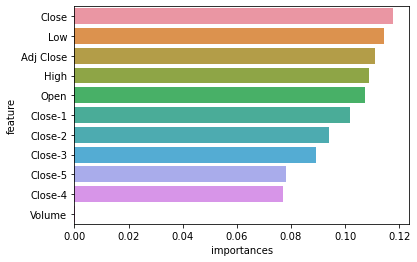

In [2]:
n = day_n/training_set.shape[0]
(X_trainRF, X_testRF, Y_trainRF, Y_testRF) = train_test_split(data_set , label_set, test_size=n,shuffle=False )

training_set.head()

from sklearn.ensemble import ExtraTreesRegressor
import seaborn as sns
forest = ExtraTreesRegressor(n_estimators=2500, random_state=0)
forest.fit(X_trainRF, Y_trainRF) 

importances = forest.feature_importances_ 
select = pd.DataFrame(importances)
select.columns = ["importances"] 
select['feature']=list(X_trainRF.columns)
select = select.sort_values(by=['importances'], ascending=False)
sns.barplot(y= 'feature',x = 'importances',data=select)

select = select.drop(select[select['importances']>importance_n].index)
training_set = training_set.drop(training_set[select['feature']], axis=1)

data_set = training_set.drop(['Date','Label'], axis=1)
label_set= training_set.drop(training_set.columns.difference(['Label']), axis=1)
(X_train, X_test, Y_train, Y_test) = train_test_split(data_set , label_set, test_size=n,shuffle=False )

In [3]:
X_df = pd.DataFrame([], columns=['Y_RFR_pred', 'Y_svm_pred', 'Y_KNN_pred', 'Y_BR_pred'])
Y_df = pd.DataFrame([], columns=['Label'])

set_m1 = set_train_model()

blank = int(len(Y_train)/10)
for i in range(blank,len(Y_train)-blank,blank):
    print('train :0',i)
    print('test :',i,i+blank)

    set_m1 = set_train_fit(X_train[0:i], Y_train[0:i], set_m1)
    out1   = train_predict(X_train[i:i+blank], Y_train[i:i+blank], set_m1)
    X_df=pd.concat([X_df,out1])
    Y_df=pd.concat([Y_df,Y_train[i:i+blank]])
X_df.index = range(len(X_df))
Y_df.index = range(len(Y_df))

train :0 337
test : 337 674
train :0 674
test : 674 1011
train :0 1011
test : 1011 1348
train :0 1348
test : 1348 1685
train :0 1685
test : 1685 2022
train :0 2022
test : 2022 2359
train :0 2359
test : 2359 2696
train :0 2696
test : 2696 3033
train :0 3033
test : 3033 3370


In [4]:
set_m2 = set_train_model()
set_m2 =set_train_fit(X_df, Y_df, set_m2)

model_one_out = train_predict(X_test, Y_test, set_m1)
model_Two_out = train_predict(model_one_out, Y_test, set_m2)

single_test_result
	RandomForestRegressor:
 		RMSE:0.020152241174310966
		MAPE:2.4185833713064744
	svm.SVR:
 		RMSE:0.016491830100988952
		MAPE:1.738344253405904
	KNN:
 		RMSE:0.021347111217144926
		MAPE:2.23867976179783
	BayesianRidge:
 		RMSE:0.015713941271209328
		MAPE:1.63912280788331

hybrid_test_result
	RandomForestRegressor:
 		RMSE:0.01897297912831553
		MAPE:2.054126558667766
	svm.SVR:
 		RMSE:0.01627909965333217
		MAPE:1.7254544850278202
	KNN:
 		RMSE:0.022104238234046284
		MAPE:2.777972841549037
	BayesianRidge:
 		RMSE:0.015973811862795832
		MAPE:1.6857353376023592



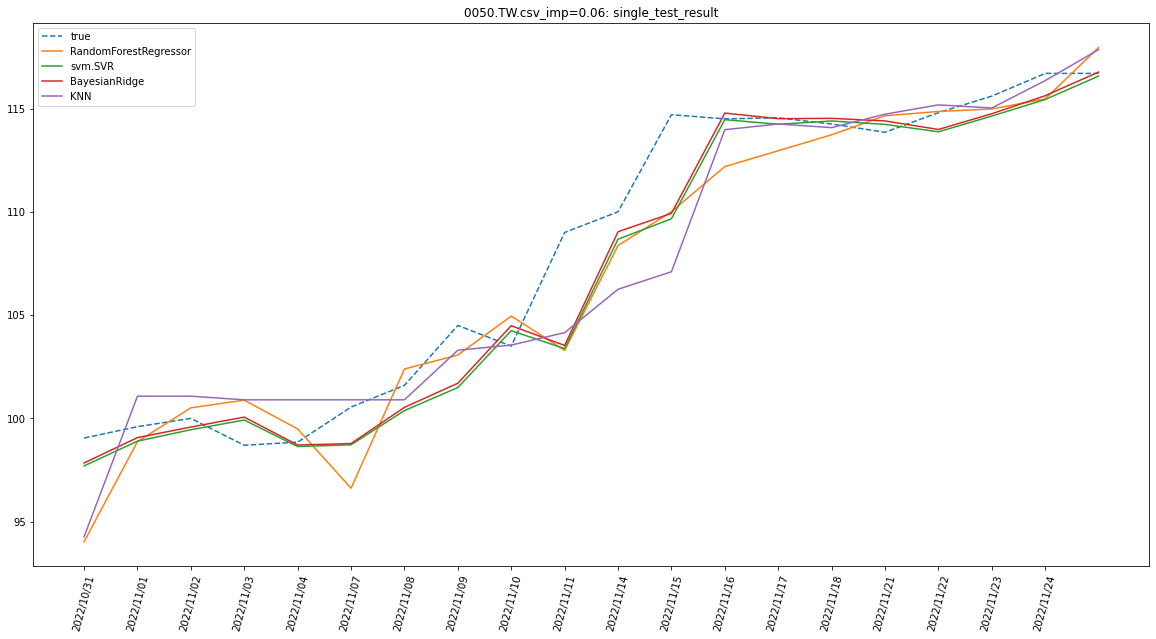

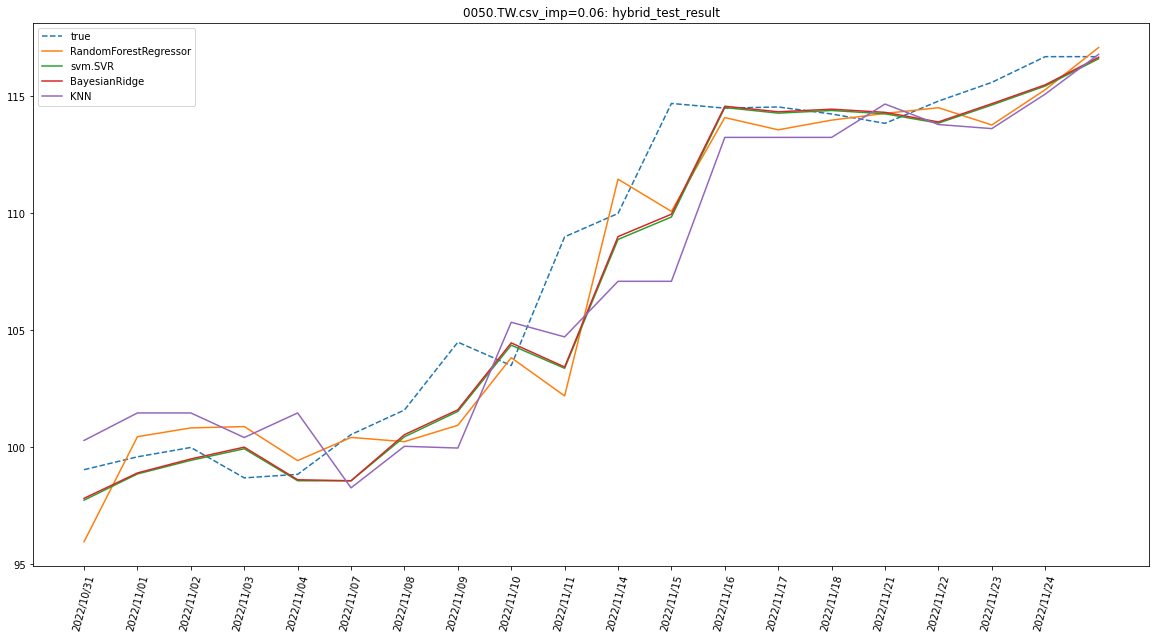

In [5]:
file_name=file_name+'_imp='+str(importance_n)
e1_name = file_name+': single_test_result'
print('single_test_result')
print_evaluation(X_test, Y_test, model_one_out,e1_name) 
show_plot_dataframe(e1_name, model_one_out, Y_test,e1_name,label_nal,training_set) 

print('hybrid_test_result')
e2_name = file_name+': hybrid_test_result'
print_evaluation(X_test, Y_test, model_Two_out,e2_name) 
show_plot_dataframe(e2_name, model_Two_out, Y_test,e2_name,label_nal,training_set)

set_m3= set_train_model()
set_m3 =set_train_fit(X_trainRF, Y_trainRF, set_m3)
out3 = train_predict(X_testRF, Y_testRF, set_m3)

In [6]:
pd.concat([X_train,Y_train],axis=1)[3365:3370]

,Open,High,Low,Close-5,Close-4,Close-3,Close-2,Close-1,Close,Adj Close,Label
3365,0.579842,0.574477,0.572355,0.633197,0.639344,0.624590,0.579508,0.575410,0.565574,0.565574,0.588934
3366,0.589604,0.588839,0.589592,0.639344,0.624590,0.579508,0.575410,0.565574,0.588934,0.588934,0.573361
3367,0.574961,0.570784,0.572765,0.624590,0.579508,0.575410,0.565574,0.588934,0.573361,0.573361,0.582787
3368,0.587570,0.582684,0.580153,0.579508,0.575410,0.565574,0.588934,0.573361,0.582787,0.582787,0.571721
3369,0.581876,0.578170,0.576869,0.575410,0.565574,0.588934,0.573361,0.582787,0.571721,0.571721,0.567213


In [7]:
pd.concat([X_df,Y_df],axis=1)[-5:]

,Y_RFR_pred,Y_svm_pred,Y_KNN_pred,Y_BR_pred,Label
3028,0.583607,0.565703,0.585861,0.566122,0.588934
3029,0.586672,0.588395,0.593648,0.590342,0.573361
3030,0.585402,0.571557,0.593648,0.572322,0.582787
3031,0.598865,0.581742,0.598566,0.583238,0.571721
3032,0.597127,0.570908,0.597746,0.571842,0.567213
